In [ ]:
import pandas

from IPython.display import clear_output
from matplotlib import pyplot
from panoptes_client import Classification, Panoptes

from datetime import datetime
from getpass import getpass

import json
import pytz
import time

In [ ]:
PROJECT_ID = 14770
START_DATETIME = pytz.UTC.localize(datetime.now())
START_DATETIME

In [ ]:
Panoptes.connect(username=input(), password=getpass())

## Pre-load the last classifications export

In [250]:
try:
    previous_classifications = pandas.read_pickle('data/classifications.pkl')
except FileNotFoundError:
    previous_classifications = pandas.read_csv(
        "data/superwasp-black-hole-hunters-classifications.csv",
        converters={'annotations': json.loads},
        parse_dates=['created_at'],
    ).set_index('classification_id')
    previous_classifications['lensed'] = previous_classifications.annotations.apply(
        lambda a: a[0]['value'] == 'Yes'
    )
    previous_classifications = previous_classifications[['lensed', 'subject_ids', 'created_at']]
    previous_classifications['created_at'] = previous_classifications['created_at'].dt.tz_localize('UTC')
    previous_classifications.to_pickle('data/classifications.pkl')

In [253]:
try:
    session_stats = pandas.read_pickle('data/stats.pkl')
except FileNotFoundError:
    session_stats = pandas.DataFrame({
        'timestamp': [],
        'agreement': [],
        'total': [],
    })

## Catch up on classifications since the last export

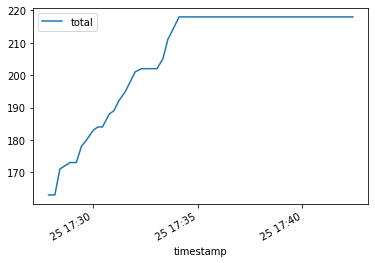

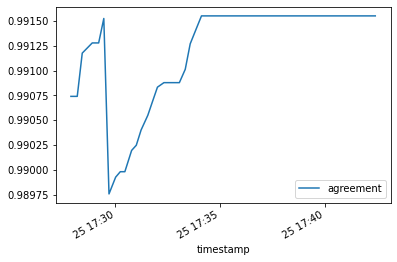

KeyboardInterrupt: 

In [254]:
while True:
    new_classifications = {
        'classification_id': [],
        'subject_ids': [],
        'lensed': [],
        'created_at': [],
    }
    for classification in Classification.where(
        scope='project', project_id=14770, last_id=previous_classifications.iloc[-1].name,
        page_size=100,
    ):
        new_classifications['classification_id'].append(classification.id)
        new_classifications['subject_ids'].append(classification.links.subjects[0].id)
        new_classifications['lensed'].append(classification.annotations[0]['value'] in ('Yes', 0, '0'))
        new_classifications['created_at'].append(classification.created_at)
    new_classifications = pandas.DataFrame(new_classifications).set_index('classification_id')
    new_classifications['created_at'] = pandas.to_datetime(new_classifications['created_at'])
    previous_classifications = pandas.concat([previous_classifications, new_classifications])
    previous_classifications.to_pickle('data/classifications.pkl')

    session_classifications = previous_classifications[previous_classifications['created_at'].gt(START_DATETIME)]
    session_subjects = session_classifications['subject_ids'].drop_duplicates()
    all_subject_classifications = previous_classifications[previous_classifications['subject_ids'].isin(session_subjects)]

    aggregated_classifications = all_subject_classifications.pivot_table(
        columns=['lensed'],
        values='lensed',
        index='subject_ids',
        aggfunc=lambda x: len(x.unique()),
        fill_value=0,
    )
    aggregated_classifications['consensus'] = aggregated_classifications.apply(
        lambda c: c[1.0] > c[0.0],
        axis=1,
    )
    aggregated_classifications['total'] = aggregated_classifications[True] + aggregated_classifications[False]
    aggregated_classifications['agreement'] = aggregated_classifications.apply(
        lambda c: c[c['consensus']] / c['total'],
        axis=1,
    )

    mean_agreement = aggregated_classifications['agreement'].mean()

    session_stats = pandas.concat((
        session_stats,
        pandas.DataFrame({
            'timestamp': [pytz.UTC.localize(datetime.now())],
            'total': [len(session_classifications)],
            'agreement': [mean_agreement],
        })
    ))
    session_stats.to_pickle('data/stats.pkl')
    clear_output(wait=True)
    session_stats.plot(x='timestamp', y='total')
    pyplot.show()
    session_stats.plot(x='timestamp', y='agreement')
    pyplot.show()
    time.sleep(10)